# A BWR geometry 
This notebook can be used as a template for modeling BWR reactors.

In [49]:
%matplotlib inline
import openmc

In [50]:
# Materials definitions

uo2 = openmc.Material(name='UO2')
uo2.add_element('U', 1.0, enrichment=1.5)
uo2.add_element('O', 2.0)
uo2.set_density('g/cc', 10.0)

zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

steel = openmc.Material(name='Stainless Steel')
steel.set_density('g/cm3', 8.00)
steel.add_element('C', 0.08, percent_type='wo')
steel.add_element('Si', 1.00, percent_type='wo')
steel.add_element('Mn', 2.00, percent_type='wo')
steel.add_element('P', 0.045, percent_type='wo')
steel.add_element('S', 0.030, percent_type='wo')
steel.add_element('Cr', 20.0, percent_type='wo')
steel.add_element('Ni', 11.0, percent_type='wo')
steel.add_element('Fe', 65.845, percent_type='wo')

water = openmc.Material(name='Water')
water.set_density('g/cm3', 0.76)
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([uo2, water, zircaloy, steel])

materials_file.cross_sections = "/home/rodrigo/opt/openmc_data/endfb80/cross_sections.xml"

materials_file.export_to_xml()

In [51]:
# Geometry definitions

In [52]:
bottom = openmc.ZPlane(z0=-1.0, boundary_type = 'reflective')
top = openmc.ZPlane(z0=1.0, boundary_type = 'reflective')

In [53]:
pitch = 1.6256
pin_cell_box = openmc.rectangular_prism(width=pitch, height=pitch)

In [54]:
# Geometry definitions for the fuel rod

fuel_or  = openmc.ZCylinder(r=1.0414/2, name='Fuel OR')
fclad_ir = openmc.ZCylinder(r=1.06426/2, name='Clad IR')
fclad_or = openmc.ZCylinder(r=1.22682/2, name='Clad OR')

fuel_region = -fuel_or 
gap_region  = +fuel_or & -fclad_ir
fclad_region  = +fclad_ir & -fclad_or
fwater_region = pin_cell_box & +fclad_or

fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = uo2
fuel_cell.region = fuel_region 

gap_cell = openmc.Cell(name='air gap')
gap_cell.region = gap_region

clad_cell = openmc.Cell(name='clad')
clad_cell.fill = zircaloy
clad_cell.region = fclad_region

fwater_cell = openmc.Cell(name='fwater')
fwater_cell.fill = water
fwater_cell.region = fwater_region

fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])

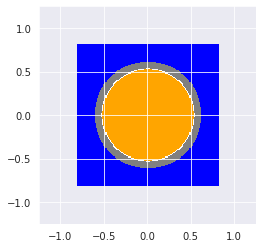

In [55]:
fuel_pin_universe.plot(width=(2.5, 2.5), colors = {fuel_cell: 'orange', gap_cell: 'white', clad_cell: 'grey', fwater_cell: 'blue'})

In [56]:
# Geometry definitions for the water rod

water_or = openmc.ZCylinder(r=1.34874/2)
wclad_or = openmc.ZCylinder(r=1.50114/2)

wwater_inner_region = -water_or
wclad_region = -wclad_or & +water_or 
wwater_outer_region = pin_cell_box & +wclad_or

wwater_inner_cell = openmc.Cell(name='wwater_inner')
wwater_inner_cell.region = wwater_inner_region
wwater_inner_cell.fill = water

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

wwater_outer_cell = openmc.Cell(name='wwater_outer')
wwater_outer_cell.fill = water
wwater_outer_cell.region = wwater_outer_region

water_pin_universe = openmc.Universe(cells=[wwater_inner_cell, wclad_cell, wwater_outer_cell])

In [57]:
# Geometry definitions for the corner rod

corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name = 'Corner Cell: Fuel OR')
corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name = 'Corner Cell: Clad IR')
corner_clad_or = openmc.ZCylinder(r=1.22682/2, name = 'Corner Cell: Clad OR')

corner_fuel_cell = openmc.Cell(name='fuel')
corner_fuel_cell.fill = uo2
corner_fuel_cell.region = -corner_fuel_or 

corner_gap_cell = openmc.Cell(name='air gap')
corner_gap_cell.region = -corner_clad_ir & +corner_fuel_or

corner_clad_cell = openmc.Cell(name='clad')
corner_clad_cell.fill = zircaloy
corner_clad_cell.region = +corner_clad_ir & -corner_clad_or

In [58]:
# Defining an Assembly

In [59]:
margin = 1e-8
sleave_thickness = 0.2032
sleave_inner_radius = 0.9652 + margin

In [60]:
ur_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ur Corner Cell: Fuel OR')
ur_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ur Corner Cell: Clad IR')
ur_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ur Corner Cell: Clad OR')

ur_corner_fuel_cell = openmc.Cell(name='ur fuel')
ur_corner_fuel_cell.fill = uo2
ur_corner_fuel_cell.region = -ur_corner_fuel_or 

ur_corner_gap_cell = openmc.Cell(name='ul air gap')
ur_corner_gap_cell.region = -ur_corner_clad_ir & +ur_corner_fuel_or

ur_corner_clad_cell = openmc.Cell(name='ul clad')
ur_corner_clad_cell.fill = zircaloy
ur_corner_clad_cell.region = +ur_corner_clad_ir & -ur_corner_clad_or

ur_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius)
ur_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius+sleave_thickness)

ur_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
ur_sleave_ver_bound = openmc.YPlane(y0=pitch/2 - sleave_inner_radius + margin)

ur_sleave_cell = openmc.Cell(name='ur sleave cell')
ur_sleave_cell.region = -ur_sleave_or & +ur_sleave_ir & +ur_sleave_hor_bound & +ur_sleave_ver_bound & pin_cell_box
ur_sleave_cell.fill = zircaloy

ur_sleave_water_cell = openmc.Cell(name = 'ur sleave water')
ur_sleave_water_cell.region = pin_cell_box & +ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_or
ur_sleave_water_cell.fill = water

ur_sleave_ver_water_cell = openmc.Cell(name='ur vertically-equivalent sleave water')
ur_sleave_ver_water_cell.region = pin_cell_box & -ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_ver_water_cell.fill = water 

ur_opposite_water_cell = openmc.Cell(name='ur opposite water')
ur_opposite_water_cell.region = pin_cell_box & -ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_opposite_water_cell.fill = water 

ur_sleave_hor_water_cell = openmc.Cell(name='ur horizontally-equivalent sleave water')
ur_sleave_hor_water_cell.region = pin_cell_box & +ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_hor_water_cell.fill = water 

ur_inner_water_cell = openmc.Cell(name='ur inner water cell')
ur_inner_water_cell.region = pin_cell_box & -ur_sleave_ir & +ur_corner_clad_or
ur_inner_water_cell.fill = water

ur_corner_pin_universe = openmc.Universe(cells=[ur_corner_fuel_cell, ur_corner_gap_cell, ur_corner_clad_cell, ur_sleave_cell, ur_inner_water_cell, ur_sleave_water_cell, ur_sleave_ver_water_cell, ur_opposite_water_cell, ur_sleave_hor_water_cell])

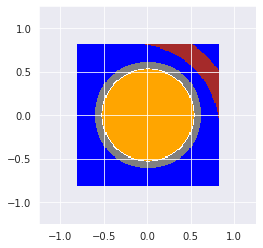

In [61]:
ur_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ur_corner_fuel_cell: 'orange', ur_corner_gap_cell: 'white', ur_corner_clad_cell: 'grey', ur_sleave_cell:'brown', ur_inner_water_cell: 'blue', ur_sleave_water_cell: 'blue', ur_sleave_ver_water_cell: 'blue', ur_opposite_water_cell: 'blue', ur_sleave_hor_water_cell: 'blue'})

In [62]:
ul_corner_fuel_or = openmc.ZCylinder(r=(1.0414/2), name='ul Corner Cell: Fuel OR')
ul_corner_clad_ir = openmc.ZCylinder(r=(1.06426/2), name='ul Corner Cell: Clad IR')
ul_corner_clad_or = openmc.ZCylinder(r=(1.22682/2), name='ul Corner Cell: Clad OR')

ul_corner_fuel_cell = openmc.Cell(name='ul fuel')
ul_corner_fuel_cell.fill = uo2
ul_corner_fuel_cell.region = -ul_corner_fuel_or 

ul_corner_gap_cell = openmc.Cell(name='ul air gap')
ul_corner_gap_cell.region = -ul_corner_clad_ir & +ul_corner_fuel_or

ul_corner_clad_cell = openmc.Cell(name='ul clad')
ul_corner_clad_cell.fill = zircaloy
ul_corner_clad_cell.region = +ul_corner_clad_ir & -ul_corner_clad_or

ul_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius) #Shouldn't have margin
ul_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius + sleave_thickness)

ul_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ul_sleave_ver_bound = openmc.YPlane(y0=pitch/2-sleave_inner_radius+margin)

ul_sleave_cell = openmc.Cell(name='ul sleave cell')
ul_sleave_cell.region = -ul_sleave_or & +ul_sleave_ir & -ul_sleave_hor_bound & +ul_sleave_ver_bound & pin_cell_box
ul_sleave_cell.fill = zircaloy

ul_sleave_water_cell = openmc.Cell(name='ul sleave water')
ul_sleave_water_cell.region = pin_cell_box & -ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_or
ul_sleave_water_cell.fill = water

ul_sleave_ver_water_cell = openmc.Cell(name='ul vertically-equivalent sleave water')
ul_sleave_ver_water_cell.region = pin_cell_box & +ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_ver_water_cell.fill = water 

ul_opposite_water_cell = openmc.Cell(name='ul opposite water')
ul_opposite_water_cell.region = pin_cell_box & +ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_opposite_water_cell.fill = water 

ul_sleave_hor_water_cell = openmc.Cell(name='ul horizontally-equivalent sleave water')
ul_sleave_hor_water_cell.region = pin_cell_box & -ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_hor_water_cell.fill = water 

ul_inner_water_cell = openmc.Cell(name='ul inner water cell')
ul_inner_water_cell.region = pin_cell_box & -ul_sleave_ir & +ul_corner_clad_or
ul_inner_water_cell.fill = water

ul_corner_pin_universe = openmc.Universe(cells=[ul_corner_fuel_cell, ul_corner_gap_cell, ul_corner_clad_cell, ul_sleave_cell, ul_inner_water_cell, ul_sleave_water_cell, ul_sleave_ver_water_cell, ul_opposite_water_cell, ul_sleave_hor_water_cell])

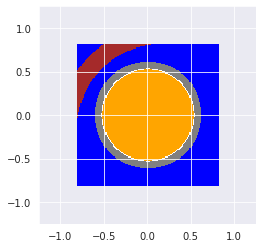

In [63]:
ul_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ul_corner_fuel_cell: 'orange', ul_corner_gap_cell: 'white', ul_corner_clad_cell: 'grey', ul_sleave_cell:'brown', ul_inner_water_cell: 'blue', ul_sleave_water_cell: 'blue', ul_sleave_ver_water_cell: 'blue', ul_opposite_water_cell: 'blue', ul_sleave_hor_water_cell: 'blue'})

In [64]:
ll_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ll Corner Cell: Fuel OR')
ll_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ll Corner Cell: Clad IR')
ll_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ll Corner Cell: Clad OR')

ll_corner_fuel_cell = openmc.Cell(name='ll fuel')
ll_corner_fuel_cell.fill = uo2
ll_corner_fuel_cell.region = -ll_corner_fuel_or 

ll_corner_gap_cell = openmc.Cell(name='ll air gap')
ll_corner_gap_cell.region = -ll_corner_clad_ir & +ll_corner_fuel_or

ll_corner_clad_cell = openmc.Cell(name='ll clad')
ll_corner_clad_cell.fill = zircaloy
ll_corner_clad_cell.region = +ll_corner_clad_ir & -ll_corner_clad_or

ll_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
ll_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

ll_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ll_sleave_ver_bound = openmc.YPlane(y0=-pitch/2+sleave_inner_radius-margin)

ll_sleave_cell = openmc.Cell(name='ul sleave cell')
ll_sleave_cell.region = -ll_sleave_or & +ll_sleave_ir & -ll_sleave_hor_bound & -ll_sleave_ver_bound & pin_cell_box
ll_sleave_cell.fill = zircaloy

ll_sleave_water_cell = openmc.Cell(name='ul sleave water')
ll_sleave_water_cell.region = pin_cell_box & -ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_or
ll_sleave_water_cell.fill = water

ll_sleave_ver_water_cell = openmc.Cell(name='ul vertically-equivalent sleave water')
ll_sleave_ver_water_cell.region = pin_cell_box & +ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_ver_water_cell.fill = water 

ll_opposite_water_cell = openmc.Cell(name='ul opposite water')
ll_opposite_water_cell.region = pin_cell_box & +ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_opposite_water_cell.fill = water 

ll_sleave_hor_water_cell = openmc.Cell(name='ul horizontally-equivalent sleave water')
ll_sleave_hor_water_cell.region = pin_cell_box & -ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_hor_water_cell.fill = water 

ll_inner_water_cell = openmc.Cell(name='ul inner water cell')
ll_inner_water_cell.region = pin_cell_box & -ll_sleave_ir & +ll_corner_clad_or
ll_inner_water_cell.fill = water

ll_corner_pin_universe = openmc.Universe(cells=[ll_corner_fuel_cell, ll_corner_gap_cell, ll_corner_clad_cell, ll_sleave_cell, ll_inner_water_cell, ll_sleave_water_cell, ll_sleave_ver_water_cell, ll_opposite_water_cell, ll_sleave_hor_water_cell])

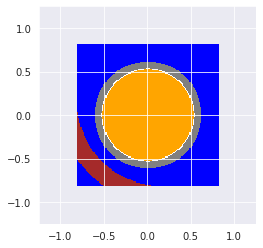

In [65]:
ll_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ll_corner_fuel_cell: 'orange', ll_corner_gap_cell: 'white', ll_corner_clad_cell: 'grey', ll_sleave_cell:'brown', ll_inner_water_cell: 'blue', ll_sleave_water_cell: 'blue', ll_sleave_ver_water_cell: 'blue', ll_opposite_water_cell: 'blue', ll_sleave_hor_water_cell: 'blue'})

In [66]:
lr_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='lr Corner Cell: Fuel OR')
lr_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='lr Corner Cell: Clad IR')
lr_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='lr Corner Cell: Clad OR')

lr_corner_fuel_cell = openmc.Cell(name='lr fuel')
lr_corner_fuel_cell.fill = uo2
lr_corner_fuel_cell.region = -lr_corner_fuel_or 

lr_corner_gap_cell = openmc.Cell(name='lr air gap')
lr_corner_gap_cell.region = -lr_corner_clad_ir & +lr_corner_fuel_or

lr_corner_clad_cell = openmc.Cell(name='lr clad')
lr_corner_clad_cell.fill = zircaloy
lr_corner_clad_cell.region = +lr_corner_clad_ir & -lr_corner_clad_or

lr_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
lr_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

lr_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
lr_sleave_ver_bound = openmc.YPlane(y0=-pitch/2 + sleave_inner_radius - margin)

lr_sleave_cell = openmc.Cell(name='ur sleave cell')
lr_sleave_cell.region = -lr_sleave_or & +lr_sleave_ir & +lr_sleave_hor_bound & -lr_sleave_ver_bound & pin_cell_box
lr_sleave_cell.fill = zircaloy

lr_sleave_water_cell = openmc.Cell(name='ur sleave water')
lr_sleave_water_cell.region = pin_cell_box & +lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_or
lr_sleave_water_cell.fill = water

lr_sleave_ver_water_cell = openmc.Cell(name='ur vertically-equivalent sleave water')
lr_sleave_ver_water_cell.region = pin_cell_box & -lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_ver_water_cell.fill = water 

lr_opposite_water_cell = openmc.Cell(name='ur opposite water')
lr_opposite_water_cell.region = pin_cell_box & -lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_opposite_water_cell.fill = water 

lr_sleave_hor_water_cell = openmc.Cell(name='ur horizontally-equivalent sleave water')
lr_sleave_hor_water_cell.region = pin_cell_box & +lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_hor_water_cell.fill = water 

lr_inner_water_cell = openmc.Cell(name='ur inner water cell')
lr_inner_water_cell.region = pin_cell_box & -lr_sleave_ir & +lr_corner_clad_or
lr_inner_water_cell.fill = water

lr_corner_pin_universe = openmc.Universe(cells=[lr_corner_fuel_cell, lr_corner_gap_cell, lr_corner_clad_cell, lr_sleave_cell, lr_inner_water_cell, lr_sleave_water_cell, lr_sleave_ver_water_cell, lr_opposite_water_cell, lr_sleave_hor_water_cell])

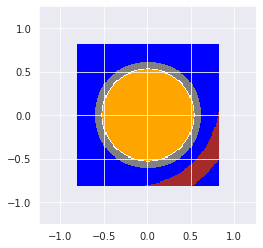

In [67]:
lr_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {lr_corner_fuel_cell: 'orange', lr_corner_gap_cell: 'white', lr_corner_clad_cell: 'grey', lr_sleave_cell:'brown', lr_inner_water_cell: 'blue', lr_sleave_water_cell: 'blue', lr_sleave_ver_water_cell: 'blue', lr_opposite_water_cell: 'blue', lr_sleave_hor_water_cell: 'blue'})

In [68]:
quarter_pitch = pitch * 8

assembly = openmc.RectLattice(name='Quarter Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-quarter_pitch/2, -quarter_pitch/2]

assembly.universes = [
                      [ul_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, ur_corner_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, water_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, water_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [ll_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, lr_corner_pin_universe]
]

assembly_region = openmc.rectangular_prism(width=quarter_pitch, height=quarter_pitch, origin=(0,0))
assembly_cell = openmc.Cell(name='quarter assembly cell', fill=assembly, region=assembly_region)

assembly_sleave = openmc.Cell(name='quarter assembly sleave')
assembly_sleave.region = openmc.rectangular_prism(width=quarter_pitch+2*sleave_thickness, height=quarter_pitch+2*sleave_thickness, corner_radius=sleave_inner_radius+sleave_thickness) & ~assembly_cell.region
assembly_sleave.fill = zircaloy

assembly_outer_water = openmc.Cell(name='assembly outer water')
assembly_outer_water.region = ~assembly_sleave.region & ~assembly_cell.region & openmc.rectangular_prism(width=quarter_pitch+2*sleave_thickness+1, height=quarter_pitch+2*sleave_thickness+1, boundary_type='reflective')
assembly_outer_water.fill = water

quarter_assembly_universe = openmc.Universe(cells=[assembly_cell, assembly_sleave, assembly_outer_water])

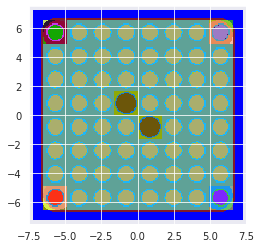

In [69]:
quarter_assembly_universe.plot(width=(15,15), colors={assembly_outer_water: 'blue'})

In [70]:
geom = openmc.Geometry(quarter_assembly_universe)
geom.export_to_xml()

In [71]:
# OpenMC simulation parameters

point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()

In [72]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################